### Applications au Clustering : ToMaTo et NNVR

**Autrice:** Rosalie Corine NKOUNGHAWE TOMEYUM

---

### Objectif

Appliquer des méthodes topologiques avancées pour effectuer un **clustering robuste** sur des données complexes, en particulier des formes non convexes comme les deux lunes.

Nous nous appuyons sur deux approches :

- **ToMaTo** (Topological Mode Analysis Tool)
- **NNVR** (Nearest-Neighbor Vietoris-Rips)

> Cette étude est inspirée du livre *Persistence theory: from quiver representations to data analysis* de Steve Oudot, notamment des sections **6.1 à 6.5**.

---

### Méthodes Présentées

#### 1. **Clustering par mode-seeking**
- Chaque point suit un **chemin de densité croissante** vers un maximum local (un **mode**).
- Cette approche permet de regrouper naturellement les points en **bassins d'attraction**.

#### 2. **ToMaTo (Topological Mode Analysis Tool)**
- On calcule la **persistance H₀** des modes obtenus.
- Un **seuil `τ`** permet de filtrer les modes peu significatifs.
- Résultat : seuls les **modes persistants** sont retenus comme clusters.

#### 3. **NNVR (Nearest-Neighbor Vietoris-Rips)**
- Construction d’un **graphe k-NN** sur les données.
- Approximation de la **topologie** du nuage de points via un complexe simplicial.
- Permet d’analyser la **structure topologique globale** du jeu de données (composantes, cycles…).

---

### Pourquoi ces méthodes ?

Les méthodes classiques de clustering (comme KMeans) supposent des clusters convexes.  
ToMaTo et NNVR exploitent la **géométrie et la topologie des données** pour détecter des clusters de formes complexes, y compris :

- Des clusters **en forme de lune**, d’anneaux, de spirales…
- Des structures **non séparables linéairement**.



### IMPORTS ET CHARGEMENT DES DONNÉES (make_noons)


In [9]:
!pip install networkx

/bin/bash: ligne 1: /export/home/users/Enseignants/vadim.lebovici/Documents/tps/.venv/bin/pip : ne peut exécuter : le fichier requis n'a pas été trouvé


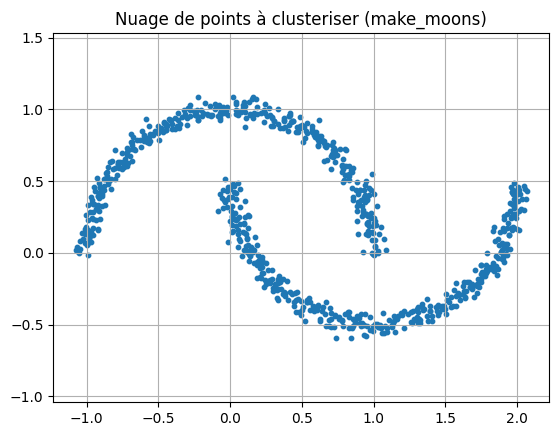

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

# Génération des données
X, y= make_moons(n_samples=800, noise=0.04, random_state=42)

# Affichage du nuage
plt.scatter(X[:, 0], X[:, 1], s=10)
plt.title("Nuage de points à clusteriser (make_moons)")
plt.axis('equal')
plt.grid(True)
plt.show()

### CONSTRUCTION DU GRAPHE NNVR (KNN)

C'est ici que la méthode **NNVR** intervient : Elle approxime la topologie des données via le graphe de voisinage.

*pseudo code*

- Pour chaque point i :
    - Trouver ses k plus proches voisins
    - Ajouter des arêtes entre i et ses voisins
- Obtenir le graphe G (non orienté, pondéré)

#### Construction du graphe 

In [11]:
import networkx as nx
from sklearn.neighbors import NearestNeighbors

k = 10
nn = NearestNeighbors(n_neighbors=k)
nn.fit(X)
distances, indices = nn.kneighbors(X)

G = nx.Graph()
G.add_nodes_from(range(len(X)))
for i in range(len(X)):
    for j in indices[i]:
        if i != j:
            G.add_edge(i, j)

ModuleNotFoundError: No module named 'networkx'

#### Affichage 

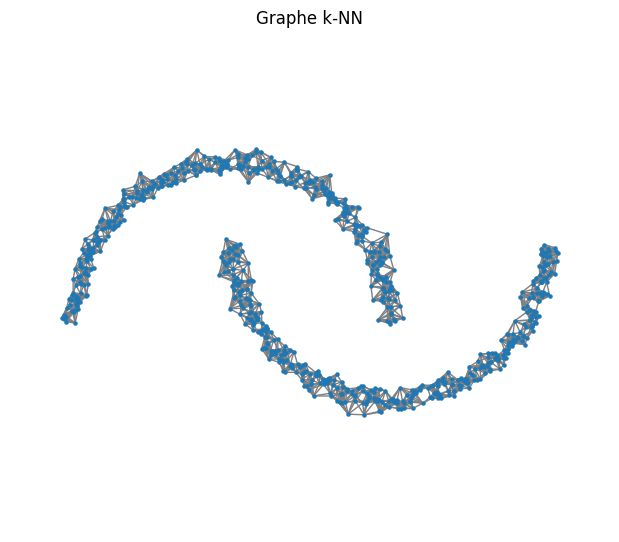

In [ ]:
pos = {i: X[i] for i in range(len(X))}
plt.figure(figsize=(6, 5))
nx.draw(G, pos, node_size=5, edge_color='gray')
plt.title("Graphe k-NN")
plt.axis('equal')
plt.show()

### Extraction des composantes connexes se trouvant dans le graphe KNN que nous venons de faire 

*pseudo code* :

- Utiliser nx.connected_components(G)
- Pour chaque composante :
    - Stocker les indices de ses points
    - Associer un label unique (labels_cc)

In [ ]:
connected_components = list(nx.connected_components(G))
component_indices = [np.array(list(comp)) for comp in connected_components]
component_indices.sort(key=lambda x: -len(x))

labels_cc = np.full(len(X), -1)
for idx, comp in enumerate(connected_components):
    for i in comp:
        labels_cc[i] = idx

In [ ]:
len(connected_components)

2

### Calcul de la densité par composante 

La fonction de densité à utiliser est le KDE (Estimation de densité par le noyau)

*pseudo code*

- Pour chaque composante connexe :
    - Appliquer une méthode de densité (ici: KDE)
    - Assigner les densités à tous les points de la composante
- Obtenir un tableau global des densités : density[i]

In [ ]:
from sklearn.neighbors import KernelDensity

densities_per_component = []
neighbors_per_component = []

for comp in component_indices:
    X_comp = X[comp]
    k_comp = min(10, len(X_comp) - 1)

    # Estimation de la densité par KDE
    kde = KernelDensity(kernel='gaussian', bandwidth=0.05) 
    kde.fit(X_comp)
    log_dens = kde.score_samples(X_comp)  # log densités
    density = np.exp(log_dens)  # convertir en densité

    # k-NN pour les voisins (utile pour le graphe)
    nn = NearestNeighbors(n_neighbors=k_comp)
    nn.fit(X_comp)
    distances, neighbors = nn.kneighbors(X_comp)

    densities_per_component.append(density)
    neighbors_per_component.append(neighbors)


#### Fusion des données locales (densité + voisins) en indices globaux

In [ ]:
# Création de la densité globale (initialisée avec des zéros)
density_global = np.zeros(len(X))
neighbors_global = [None] * len(X)  # pour stocker les voisins de chaque point

for comp_indices, dens, neighbors in zip(component_indices, densities_per_component, neighbors_per_component):
    for local_idx, global_idx in enumerate(comp_indices):
        density_global[global_idx] = dens[local_idx]
        # Transformation des indices locaux en indices globaux
        neighbors_global[global_idx] = comp_indices[neighbors[local_idx]]


### Mode-seeking (chaque point grimpe vers un voisin plus dense dans sa composante)

*pseudo code*

- Initialiser parent[i] = i pour tout i
- Trier les points par densité décroissante
- Pour chaque point i :
    - Considérer ses voisins j dans G
    - Si j est dans la même composante et densité[j] > densité[i] :
        - parent[i] = j
        - arrêter (i grimpe vers j)

In [ ]:
parent = np.arange(len(X))  # Initialisation : chaque point est son propre parent
sorted_indices = np.argsort(-density_global)  # Tri par densité décroissante

for i in sorted_indices:
    if neighbors_global[i] is None:
        continue
    for j in neighbors_global[i]:
        if labels_cc[j] == labels_cc[i] and density_global[j] > density_global[i]:
            parent[i] = j  # i grimpe vers j
            break


### Compression des chemins et calcul des représentants

*pseudo code*
- Pour chaque point i :
    - Trouver son représentant racine avec compression de chemin

In [ ]:
def find(i):
    if parent[i] != i:
        parent[i] = find(parent[i])
    return parent[i]

representants = np.array([find(i) for i in range(len(X))])


### Calcul de la persistance 
La persistance d’un mode correspond à la différence entre :

- birth = densité du mode (point qui n’a pas de parent plus dense)

- death = densité la plus haute des points qui "pointent vers lui"

*pseudo code*

- Pour chaque représentant :
    - birth = densité du représentant
    - death = max(densité des points qui grimpent vers lui)
    - persistence = birth - death

In [ ]:
birth = density_global.copy()
death = np.zeros(len(X))

for i in range(len(X)):
    rep = representants[i]
    if rep != i:
        death[rep] = max(death[rep], density_global[i])

persistence = birth - death


In [ ]:
import numpy as np
print("Top persistances :", np.sort(persistence)[-10:])


Top persistances : [2.44161364 2.4468369  2.44976804 2.4549889  2.47609192 2.4970656
 2.52131838 2.52547342 2.52825826 2.5637285 ]


### Affichage du diagramme de persistance 

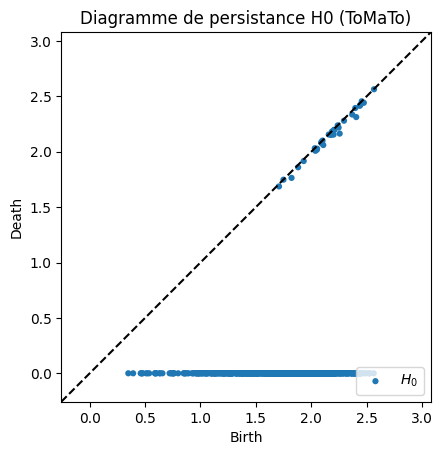

In [ ]:
import matplotlib.pyplot as plt
from persim import plot_diagrams

# Points pour le diagramme H0 (naissance != mort)
points = np.array([[birth[i], death[i]] for i in range(len(X)) if birth[i] > death[i]])

# Affichage du diagramme
plot_diagrams([points], show=True, title="Diagramme de persistance H0 (ToMaTo)")



### Commentaire

Ce diagramme montre bien deux points qui sont bien éloignés de la diagonale 

### Choix du tau optimal

*pseudo code* 
- Trier les persistance par ordre décroissant
- Option 1 : tau = moyenne des 2ème et 3ème plus grandes persistance
- Option 2 : tau = seuil de plus grand saut (gap) dans les persistance (celle que nous avons utilisée)


In [ ]:
sorted_persistence = np.sort(persistence)[::-1]
diffs = np.diff(sorted_persistence)
idx_max_jump = np.argmax(diffs)
tau = sorted_persistence[idx_max_jump + 1]

print(f"Seuil optimal tau choisi : {tau:.2f}")


Seuil optimal tau choisi : 1.32


### Clustering final avec filtrage par persistence

*pseudo code*
- Pour chaque point i :
    - Grimper jusqu’à un mode persistant >= tau
    - Assigner une étiquette selon le mode atteint

In [ ]:
def climb_to_persistent_mode(i, parent, persistence, tau):
    while parent[i] != i:
        i = parent[i]
        if persistence[i] >= tau:
            return i
    return i if persistence[i] >= tau else -1

final_labels = np.full(len(X), -1)
label_id = 0

for i in range(len(X)):
    rep = climb_to_persistent_mode(i, parent, persistence, tau)
    if rep != -1:
        if final_labels[rep] == -1:
            final_labels[rep] = label_id
            label_id += 1
        final_labels[i] = final_labels[rep]


### Score de silhouette et affichage final du graphe de clustering 

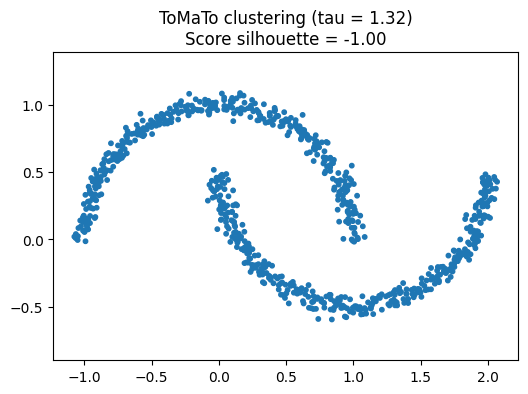

In [ ]:
from sklearn.metrics import silhouette_score

# On ignore les points sans cluster (label -1)
mask = final_labels != -1
X_valid = X[mask]
labels_valid = final_labels[mask]

if len(np.unique(labels_valid)) > 1:
    score = silhouette_score(X_valid, labels_valid)
else:
    score = -1

# Affichage
plt.figure(figsize=(6, 4))
plt.scatter(X[:, 0], X[:, 1], c=final_labels, cmap='tab10', s=10)
plt.title(f"ToMaTo clustering (tau = {tau:.2f})\nScore silhouette = {score:.2f}")
plt.axis('equal')
plt.show()


### Commentaire 

Avec cette approche, on se rend compte que la fonction de densité est trop lisse, elle génère trop de modes plats, et toutes les données sont mises dans un même cluster ce qui nous permet donc de nous limiter à l'utilisation de l'inverser des moyennes des distances comme notre fonction de densité dans cette application de l'algorithme décrit dans l'article.


#### Changeons la fonction de densité en utilisant l'inverse de la moyenne des distances 

### Calcul de la densité par composante 

In [ ]:
densities_per_component = []
neighbors_per_component = []

for comp in component_indices:
    X_comp = X[comp]
    k_comp = min(10, len(X_comp) - 1)
    nn = NearestNeighbors(n_neighbors=k_comp)
    nn.fit(X_comp)
    distances, neighbors = nn.kneighbors(X_comp)
    density = 1 / (np.mean(distances[:, 1:], axis=1) + 1e-6)
    densities_per_component.append(density)
    neighbors_per_component.append(neighbors)


### Mode-seeking (union-find) pour chaque composante 

In [ ]:
parent = np.full(len(X), -1)
density_global = np.zeros(len(X))

for comp_idx, comp in enumerate(component_indices):
    X_comp = X[comp]
    local_density = densities_per_component[comp_idx]
    local_neighbors = neighbors_per_component[comp_idx]
    idx_map = {i: comp[i] for i in range(len(comp))}
    local_order = np.argsort(-local_density)

    for local_i in range(len(comp)):
        global_i = idx_map[local_i]
        parent[global_i] = global_i
        density_global[global_i] = local_density[local_i]

    for local_i in local_order:
        global_i = idx_map[local_i]
        for local_j in local_neighbors[local_i]:
            if local_j == local_i:
                continue
            global_j = idx_map[local_j]
            if local_density[local_j] > local_density[local_i]:
                parent[global_i] = global_j
                break


#### Calcul de la persistence 

In [ ]:
def find(i):
    if parent[i] != i:
        parent[i] = find(parent[i])
    return parent[i]

representants = np.array([find(i) for i in range(len(X))])
birth = density_global.copy()
death = np.zeros_like(birth)
for i in range(len(X)):
    rep = representants[i]
    if rep != i:
        death[rep] = max(death[rep], density_global[i])

persistence = birth - death

In [ ]:
sorted_p = np.sort(persistence)[::-1]
diffs = np.diff(sorted_p)
id_max_jump = np.argmax(diffs)
tau = sorted_p[id_max_jump + 1]

print(tau)

26.628363225463385


In [ ]:
def climb_to_persistent_mode(i, parent, persistence, tau):
    while parent[i] != i:
        i = parent[i]
        if persistence[i] >= tau:
            return i
    return i if persistence[i] >= tau else -1

final_labels = np.full(len(X), -1)
rep_to_label = {}
label_id = 0

for i in range(len(X)):
    rep = climb_to_persistent_mode(i, parent, persistence, 2.5)
    if rep != -1:
        if rep not in rep_to_label:
            rep_to_label[rep] = label_id
            label_id += 1
        final_labels[i] = rep_to_label[rep]

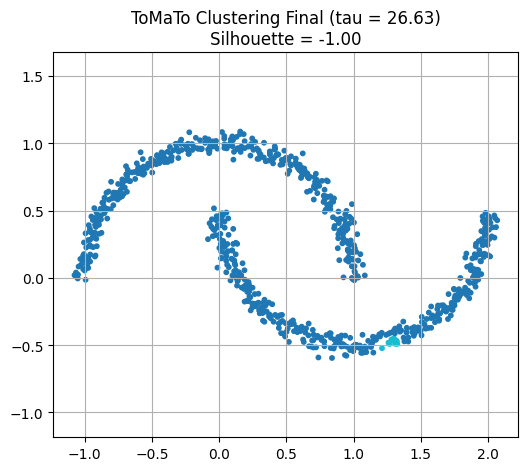

In [ ]:
from sklearn.metrics import silhouette_score

X_valid = X[final_labels != -1]
labels_valid = final_labels[final_labels != -1]
if len(np.unique(labels_valid)) > 1:
    score = silhouette_score(X_valid, labels_valid)
else:
    score = -1

plt.figure(figsize=(6, 5))
plt.scatter(X[:, 0], X[:, 1], c=final_labels, cmap='tab10', s=10)
plt.title(f"ToMaTo Clustering Final (tau = {tau:.2f})\nSilhouette = {score:.2f}")
plt.axis('equal')
plt.grid(True)
plt.show()


### Clustering TOMATO avec GUDHI 

Nous allons essayé d'effectuer le clustering de manière plus simple avec une fonction Tomato déjà implémentée dans le langage python 

In [119]:
n_noise=1000
# Générer 3 bosses disjointes de 50 points chacune
n_points_per_bump = 150
np.random.seed(123)
bumps = []
centers = [(-1, 2), (2, -1), (1, 2)]
for cx, cy in centers:
    bump = np.random.normal(loc=[cx, cy], scale=0.15, size=(n_points_per_bump, 2))
    bumps.append(bump)
bumps = np.vstack(bumps)

# Ajouter les bosses à X pour obtenir X_
# X_ = np.vstack([X, bumps])
X_ = np.vstack([X, bumps, np.random.uniform(low=-3, high=3, size=(n_noise, 2))])

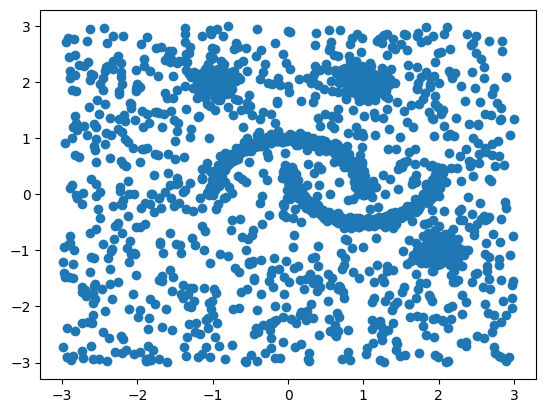

In [120]:
plt.scatter(X_[:, 0], X_[:, 1])
plt.show()

In [121]:
from gudhi.clustering.tomato import Tomato

t = Tomato()
t.fit(X_)

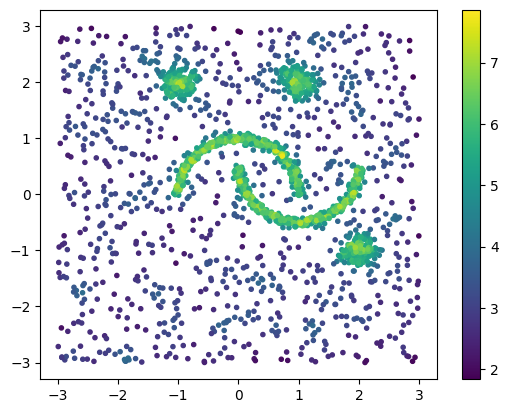

In [122]:
plt.scatter(X_[:,0],X_[:,1],marker='.',c=t.weights_)
plt.colorbar()
plt.show()

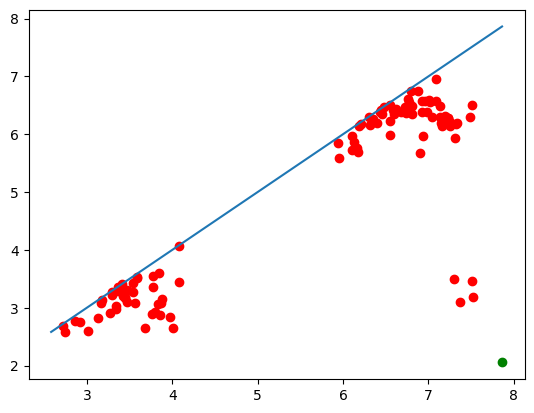

In [123]:
t.plot_diagram()

In [124]:
pers = np.concatenate([np.abs(t.diagram_[:,0] - t.diagram_[:,1]), t.max_weight_per_cc_])

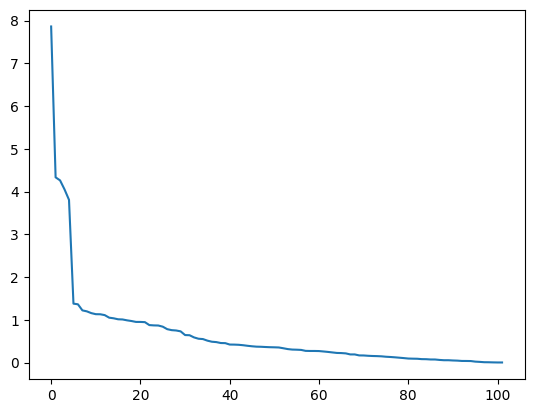

In [125]:
plt.plot(np.sort(pers)[::-1])
plt.show()

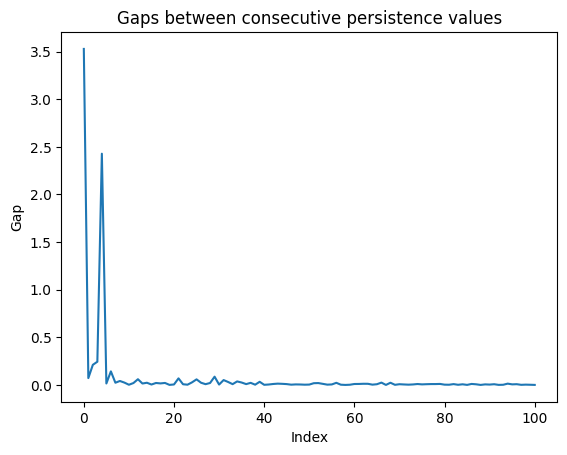

In [126]:
sorted_pers = np.sort(pers)[::-1]

gaps = [sorted_pers[i] - sorted_pers[i + 1] for i in range(len(sorted_pers) - 1)]

plt.plot(gaps)
plt.title("Gaps between consecutive persistence values")
plt.xlabel("Index")
plt.ylabel("Gap")
plt.show()


In [115]:
ind_ = np.argmax(gaps)+1
print(ind_)

1


### Clustering

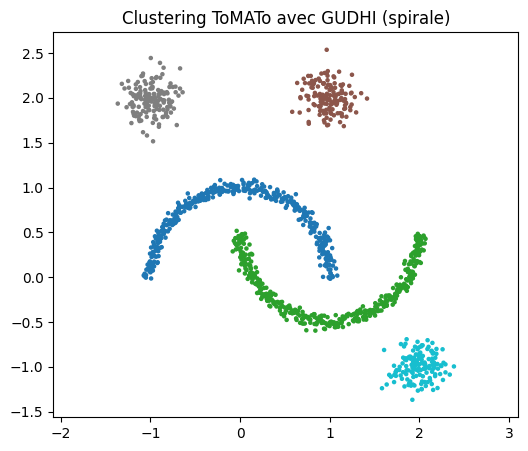

In [106]:
t.n_clusters_ = ind_
plt.figure(figsize=(6, 5))
plt.scatter(X_[:, 0], X_[:, 1], c=t.labels_, cmap='tab10', s=5)
plt.title("Clustering ToMATo avec GUDHI (spirale)")
plt.axis('equal')
plt.show()


### 7. Comparaison de cet algorithme d'analyse topologique avec les algorithmes classiques de clustering (K-Means, DBSCAN et CAH)

#### K-MEANS 

Déjà avec cette approche, il faut fixer le nombre de cluster ce qui est limitant. Nous allons donc nous servir du nombre de cluster directement détecté par la méthode ToMATo et NNVR pour voir si le score pourra être mieux 

/users/lebovici/Documents/Enseignement/M1-GT-TDA/tps/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


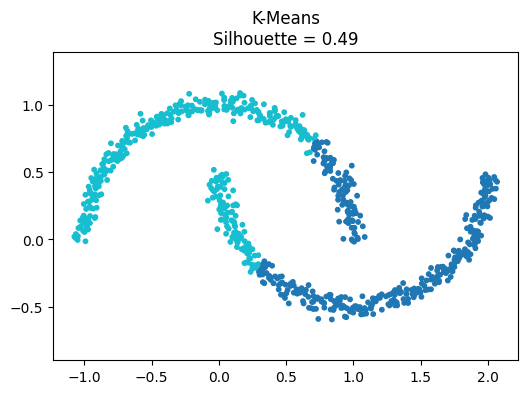

In [ ]:
from sklearn.cluster import KMeans
# K-Means
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(X)
score_kmeans = silhouette_score(X, kmeans_labels)

# Affichage du résultat
plt.figure(figsize=(6, 4))
plt.scatter(X[:, 0], X[:, 1], c=kmeans_labels, cmap='tab10', s=10)
plt.title(f"K-Means\nSilhouette = {score_kmeans:.2f}")
plt.axis('equal')
plt.show()

### Commentaire: 

Nous voyons qu'il n'est pas meilleure que ToMATo 

### DBSCAN 

Avec ce model, bien qu'on ne précise pas le nombre de clusters, il n'est pas robuste sur les données complexes

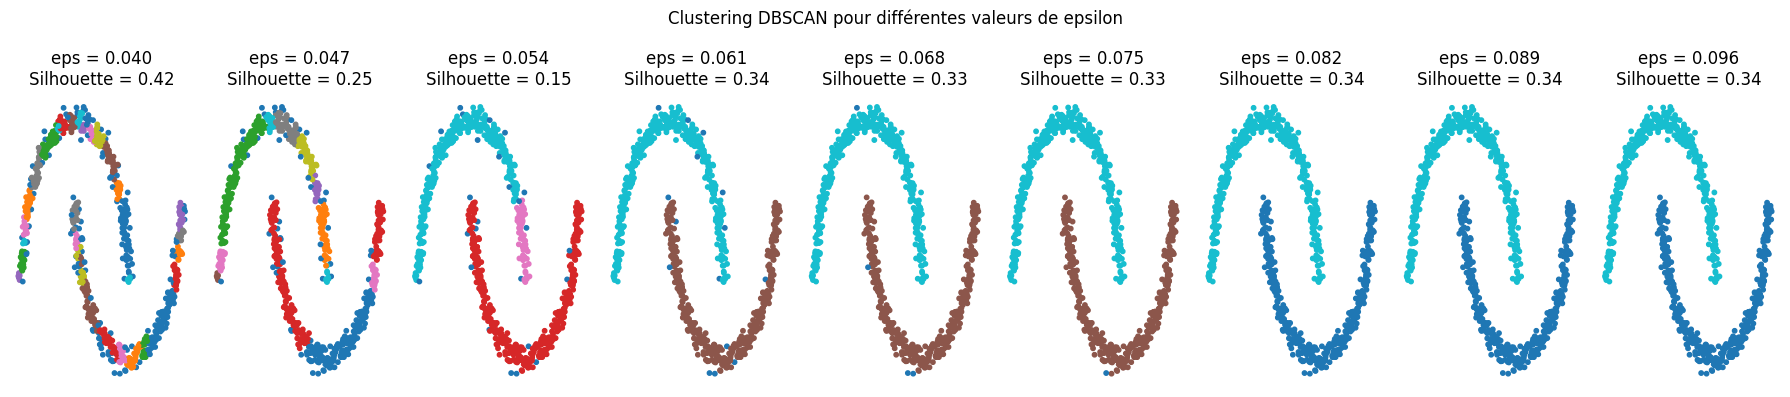

In [ ]:
# DBSCAN - Évaluation pour plusieurs valeurs de epsilon
from sklearn.cluster import DBSCAN

epsilon_values = np.arange(0.04, 0.098, 0.007)
silhouette_scores_dbscan = []
all_labels = []

fig, axes = plt.subplots(1, len(epsilon_values), figsize=(18, 4))

for idx, eps in enumerate(epsilon_values):
    dbscan = DBSCAN(eps=eps, min_samples=5)
    dbscan_labels = dbscan.fit_predict(X)
    all_labels.append(dbscan_labels)

    mask = dbscan_labels != -1
    if len(np.unique(dbscan_labels[mask])) > 1:
        score = silhouette_score(X[mask], dbscan_labels[mask])
    else:
        score = -1
    silhouette_scores_dbscan.append(score)

    axes[idx].scatter(X[:, 0], X[:, 1], c=dbscan_labels, cmap='tab10', s=10)
    axes[idx].set_title(f"eps = {eps:.3f}\nSilhouette = {score:.2f}")
    axes[idx].axis('off')

plt.suptitle("Clustering DBSCAN pour différentes valeurs de epsilon")
plt.tight_layout()
plt.show()

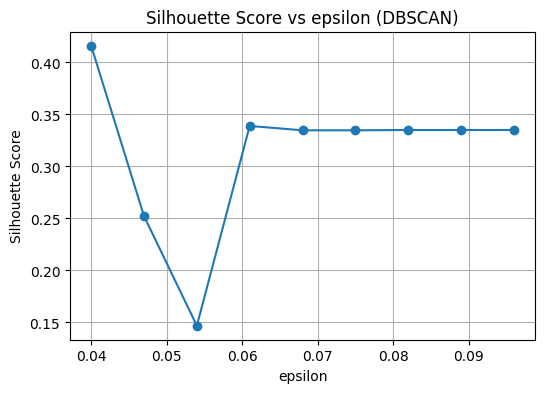

In [ ]:
# Affichage de la courbe silhouette vs epsilon
plt.figure(figsize=(6, 4))
plt.plot(epsilon_values, silhouette_scores_dbscan, marker='o')
plt.title("Silhouette Score vs epsilon (DBSCAN)")
plt.xlabel("epsilon")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

#### NMI (Normalize Mutual Information) comme métrique d'évaluation 

Le score de silhouette est plus utilisé pour les formes convexes or les deux lunes sont des formes non convexes et ont des zones de faibles densité entre elles. Du coup nous allons utiliser cette métrique Normalize Mutual Information qui est plus adapté ici (le score donné correspond bien avec la représentation visuelle du clustering)

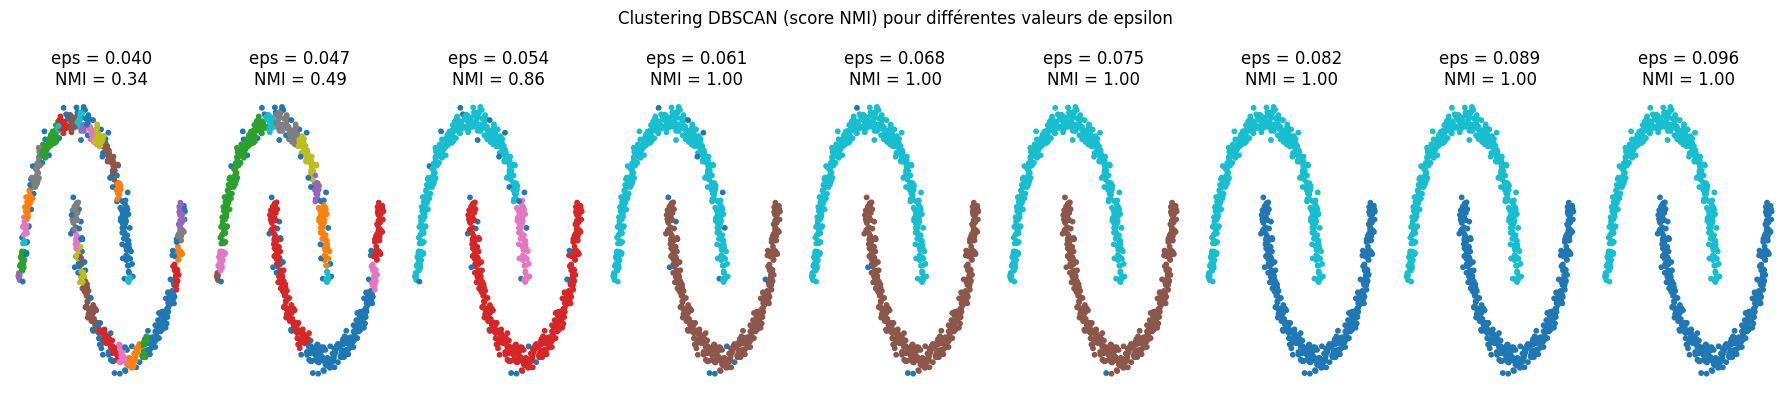

In [ ]:
from sklearn.metrics import normalized_mutual_info_score

# Évaluation DBSCAN sur différentes valeurs de epsilon avec score NMI
epsilon_values = np.arange(0.04, 0.098, 0.007)
nmi_scores_dbscan = []
all_labels = []

fig, axes = plt.subplots(1, len(epsilon_values), figsize=(18, 4))

for idx, eps in enumerate(epsilon_values):
    dbscan = DBSCAN(eps=eps, min_samples=5)
    dbscan_labels = dbscan.fit_predict(X)
    all_labels.append(dbscan_labels)

    mask = dbscan_labels != -1
    if len(np.unique(dbscan_labels[mask])) > 1:
        score = normalized_mutual_info_score(y[mask], dbscan_labels[mask])
    else:
        score = -1
    nmi_scores_dbscan.append(score)

    axes[idx].scatter(X[:, 0], X[:, 1], c=dbscan_labels, cmap='tab10', s=10)
    axes[idx].set_title(f"eps = {eps:.3f}\nNMI = {score:.2f}")
    axes[idx].axis('off')

plt.suptitle("Clustering DBSCAN (score NMI) pour différentes valeurs de epsilon")
plt.tight_layout()
plt.show()


Meilleur epsilon : 0.040 (Silhouette = 0.42)


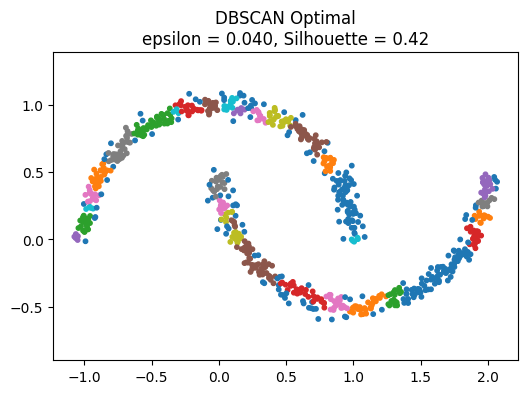

In [ ]:
# Meilleure valeur de epsilon
best_idx = np.argmax(silhouette_scores_dbscan)
best_eps = epsilon_values[best_idx]
best_score = silhouette_scores_dbscan[best_idx]
best_labels = all_labels[best_idx]

print(f"Meilleur epsilon : {best_eps:.3f} (Silhouette = {best_score:.2f})")

# Affichage du clustering DBSCAN pour le meilleur epsilon
plt.figure(figsize=(6, 4))
plt.scatter(X[:, 0], X[:, 1], c=best_labels, cmap='tab10', s=10)
plt.title(f"DBSCAN Optimal\nepsilon = {best_eps:.3f}, Silhouette = {best_score:.2f}")
plt.axis('equal')
plt.show()

### CAH 

Classification ascendente hiérarchique 

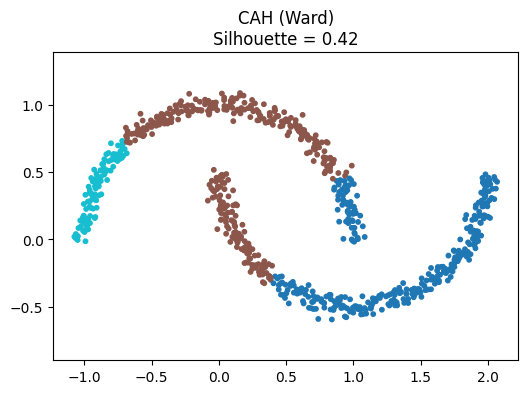

In [ ]:
# CAH (agglomératif)
from sklearn.cluster import AgglomerativeClustering

# On décide de fusionner deux cluster dont la distance maximale entre eux est la plus petite des autres distances maximale avec les 
# autres clusters  
cah = AgglomerativeClustering(n_clusters=3, linkage='complete')
cah_labels = cah.fit_predict(X)
score_cah = silhouette_score(X, cah_labels)

# Affichage du résultat CAH
plt.figure(figsize=(6, 4))
plt.scatter(X[:, 0], X[:, 1], c=cah_labels, cmap='tab10', s=10)
plt.title(f"CAH (Ward)\nSilhouette = {score_cah:.2f}")
plt.axis('equal')
plt.show()

### Conclusion

Le modèle DBSCAN est meilleure que KMEANS et CAH sur ce jeu de données mais ne l'est pas plus que le modèle ToMATo qui capture mieux la topologie des points dans le nuage de points avec un meilleur score de silhouette de 0.92 contre 0.85 du modèle DBSCAN 